In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import RidgeClassifier
import lightgbm as lgbm
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import LabelEncoder
import missingno as msno

plt.style.use('seaborn-white')
pd.set_option("display.max_rows", 50, "float_format", lambda v: "%.2f" % v )
pd.set_option('display.max_columns', 50)
# suppress the chained indexing warnings entirely
pd.set_option('mode.chained_assignment',None)

# Fixing random state for reproducibility 
seed_value = 42
np.random.seed(seed_value)
import random
random.seed(seed_value)
#from tensorflow import set_random_seed
#set_random_seed(seed_value)

%matplotlib inline

### Load training data

In [2]:
data = pd.read_csv('D:/.jupyter/Machine_Predicted_Lithology/train.csv', sep=';', memory_map=True)
data_test = pd.read_csv('D:/.jupyter/Machine_Predicted_Lithology/test.csv', sep=';', memory_map=True)

In [3]:
Alldata=pd.concat([data, data_test], axis=0).reset_index().rename(columns={'index': 'idx'})
Alldata.loc[data.index, 'Dataset'] = 'Train'
Alldata.loc[data.index.max()+1:, 'Dataset'] = 'Test'

In [4]:
Alldata.sample(10)

,idx,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Dataset
241979,241979,25/2-13 T4,3102.03,469353.91,6628710.00,-3076.63,SHETLAND GP.,Kyrre Fm.,12.85,1.81,1.70,1.66,2.55,56.58,nan,nan,4.84,90.80,122.96,12.25,nan,nan,0.60,0.10,nan,nan,nan,nan,65000.00,1.00,Train
199664,199664,17/11-1,1369.47,520153.19,6452287.50,-1342.47,SHETLAND GP.,Hod Fm.,12.38,0.21,0.56,9.98,2.52,22.49,nan,0.33,nan,78.65,30.33,nan,62.92,nan,nan,-0.30,1.17,nan,nan,nan,70032.00,1.00,Train
313883,313883,25/4-5,1540.65,454469.53,6603730.00,-1515.35,HORDALAND GP.,Grid Mb.,17.48,nan,0.79,1.11,1.93,44.70,nan,0.49,nan,125.26,nan,17.50,nan,nan,-0.02,0.00,nan,nan,nan,nan,65000.00,1.00,Train
1106379,1106379,35/8-6 S,2857.61,518245.50,6799018.00,-2643.65,SHETLAND GP.,Kyrre Fm.,12.39,nan,1.37,1.40,2.44,70.41,nan,0.28,5.11,nan,nan,12.25,37.67,nan,nan,0.02,nan,nan,38.10,nan,65000.00,1.00,Train
1234596,64085,29/3-1,3590.46,442438.88,6759337.50,-3564.27,BAAT GP.,Ness Fm.,8.73,nan,7.06,6.28,2.41,39.30,nan,0.18,3.40,87.06,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,Test
248805,248805,25/2-14,1442.29,476929.16,6625435.50,-1419.85,HORDALAND GP.,Grid Fm.,13.23,1.49,1.16,1.36,2.12,61.41,nan,nan,5.71,134.56,67.44,12.25,nan,nan,0.98,0.05,nan,nan,nan,nan,65000.00,1.00,Train
116623,116623,16/2-11 A,1366.44,475382.97,6518615.50,-1284.38,HORDALAND GP.,Skade Fm.,12.31,nan,1.07,1.07,2.08,99.45,nan,0.42,3.24,135.67,nan,12.25,43.90,nan,nan,-0.01,nan,nan,54.58,nan,65000.00,1.00,Train
1290401,119890,35/6-2 S,1773.18,548460.19,6822720.50,-1751.12,SHETLAND GP.,Kyrre Fm.,12.20,nan,1.50,1.50,2.36,63.92,nan,0.37,2.57,111.96,nan,12.25,28.96,244.22,nan,-0.01,nan,nan,30.24,nan,nan,nan,Test
775839,775839,34/10-21,2649.09,454133.78,6777267.50,-2619.67,SHETLAND GP.,Kyrre Fm.,14.04,1.61,1.68,1.43,2.26,53.19,nan,0.29,17.19,103.43,23.26,nan,nan,nan,nan,0.08,nan,nan,nan,1.61,65000.00,1.00,Train
1181244,10733,15/9-14,2113.41,423238.03,6461860.00,-2088.29,HORDALAND GP.,Utsira Fm.,13.41,nan,0.57,0.53,2.01,51.87,nan,0.54,3.14,126.67,35.27,nan,11.08,nan,nan,0.08,0.14,nan,nan,nan,nan,nan,Test


In [5]:
Alldata.GROUP.unique()

array(['NORDLAND GP.', 'HORDALAND GP.', 'ROGALAND GP.', 'SHETLAND GP.',
       'CROMER KNOLL GP.', 'VIKING GP.', 'VESTLAND GP.', 'ZECHSTEIN GP.',
       'HEGRE GP.', 'ROTLIEGENDES GP.', 'TYNE GP.', 'BOKNFJORD GP.',
       'DUNLIN GP.', 'BAAT GP.', nan], dtype=object)

In [6]:
train_wells = Alldata['WELL'][Alldata.Dataset=='Train'].unique()
print('No of train wells: %s' % len(train_wells))
#train_wells

No of train wells: 98


In [7]:
test_wells = Alldata['WELL'][Alldata.Dataset=='Test'].unique()
print('No of test wells: %s' % len(test_wells))
#test_wells

No of test wells: 10


### The LITHOLOGY column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [8]:
lithology_keys = {} # initialize dictionary
litho=['Sandstone', 'Shale', 'SandyShale', 'Limestone', 'Chalk', 'Dolomite', 
       'Marl', 'Anhydrite', 'Halite', 'Coal', 'Basement', 'Tuff']
col = np.sort(Alldata['FORCE_2020_LITHOFACIES_LITHOLOGY'][Alldata.Dataset=='Train'].unique())
for index, name in enumerate(col):
    lithology_keys[name] = litho[index]
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
lithology_keys

{30000: 'Sandstone',
 65030: 'Sandstone/Shale',
 65000: 'Shale',
 80000: 'Marl',
 74000: 'Dolomite',
 70000: 'Limestone',
 70032: 'Chalk',
 88000: 'Halite',
 86000: 'Anhydrite',
 99000: 'Tuff',
 90000: 'Coal',
 93000: 'Basement'}

Lithologies are not equally likely. This is reflected in this dataset.

In [9]:
Alldata['FORCE_2020_LITHOFACIES_LITHOLOGY'][Alldata.Dataset=='Train'].value_counts()

65000.00    720803
30000.00    168937
65030.00    150455
70000.00     56320
80000.00     33329
99000.00     15245
70032.00     10513
88000.00      8213
90000.00      3820
74000.00      1688
86000.00      1085
93000.00       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

Text(0, 0.5, 'Lithology presence (\\%)')

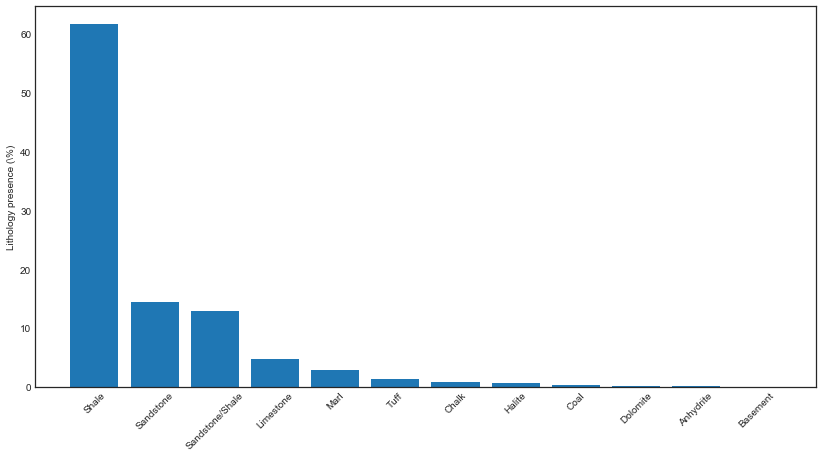

In [10]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

### Missing logs

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [11]:
dftype = pd.DataFrame(Alldata.dtypes, columns=['pd_type'])
dftype['n_unique'] = Alldata.nunique()
dftype['nan_bool'] = Alldata.isna().any()
dftype['n_nan'] = Alldata.isna().sum()
dftype

,pd_type,n_unique,nan_bool,n_nan
idx,int64,1170511,False,0
WELL,object,108,False,0
DEPTH_MD,float64,1283204,False,0
X_LOC,float64,206614,True,10834
Y_LOC,float64,21901,True,10834
Z_LOC,float64,1257014,True,10834
GROUP,object,14,True,1278
FORMATION,object,69,True,144068
CALI,float64,968434,True,93522
RSHA,float64,657313,True,637550


### Preparing data for training

In [17]:
X_all = Alldata.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 
                              'idx', 'Dataset'])

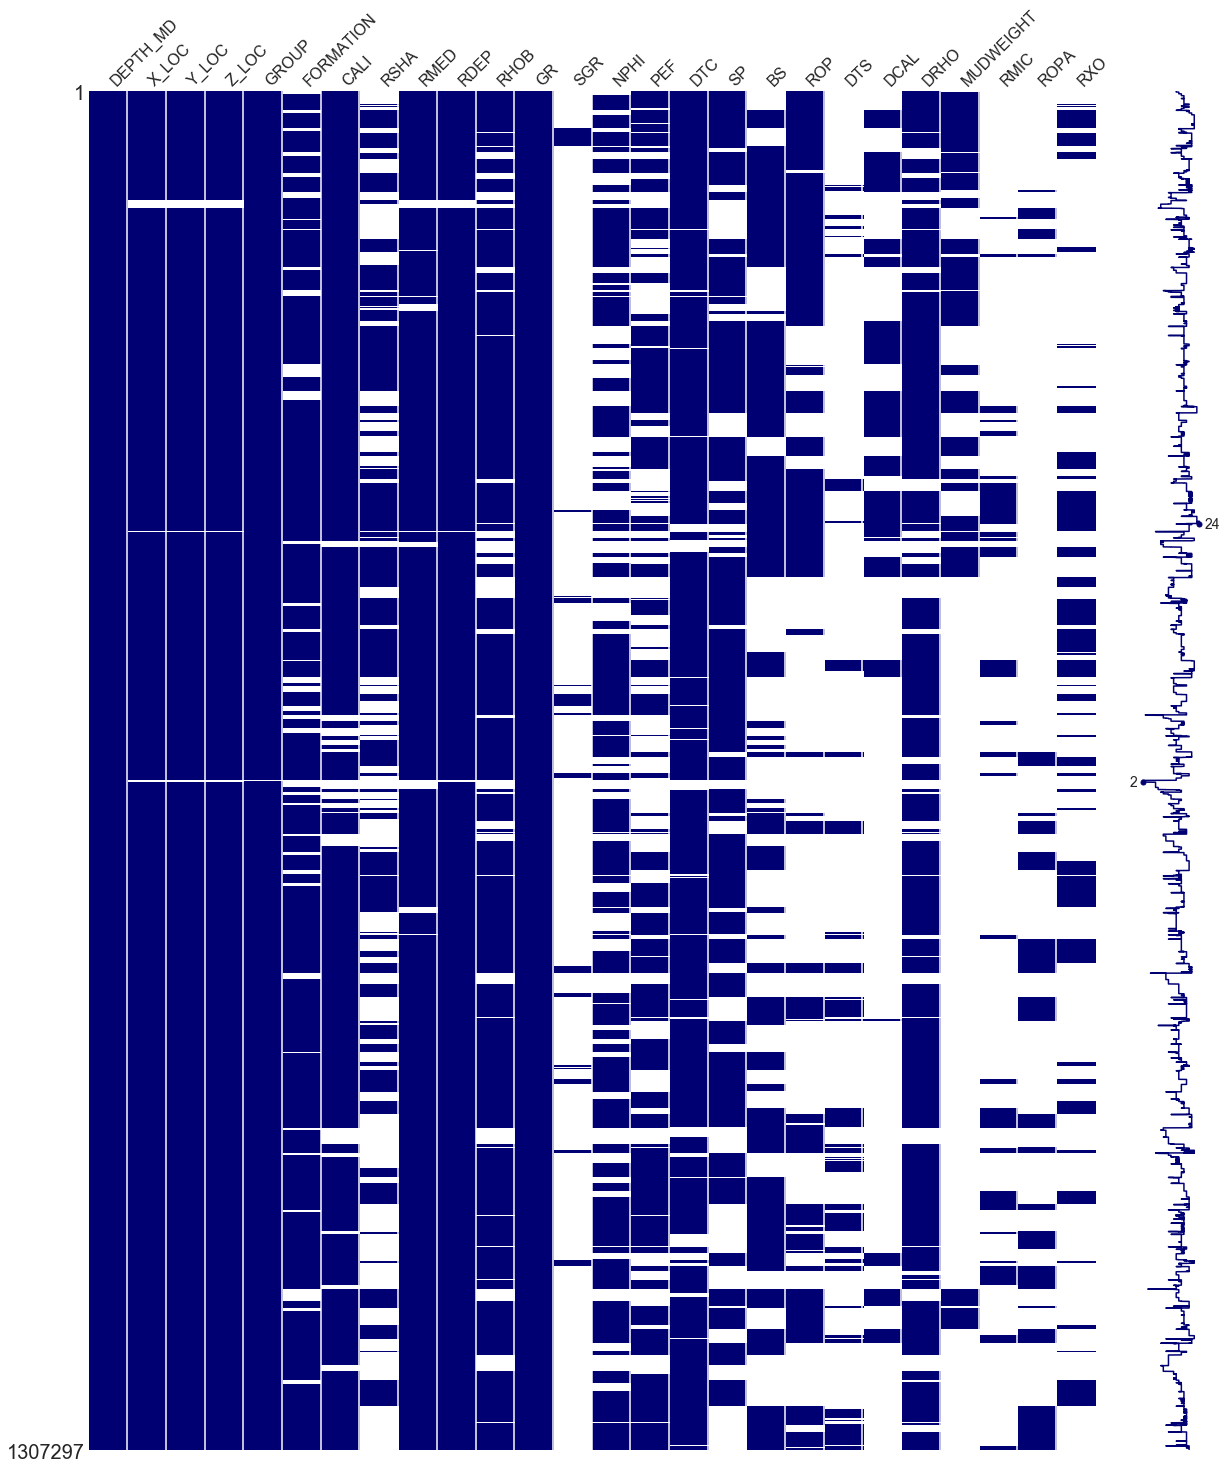

In [18]:
# Visualize missing values as a matrix
msno.matrix(X_all, color=(0., 0., 0.45))   
fig = plt.gcf()
fig.set_size_inches(20, 25)

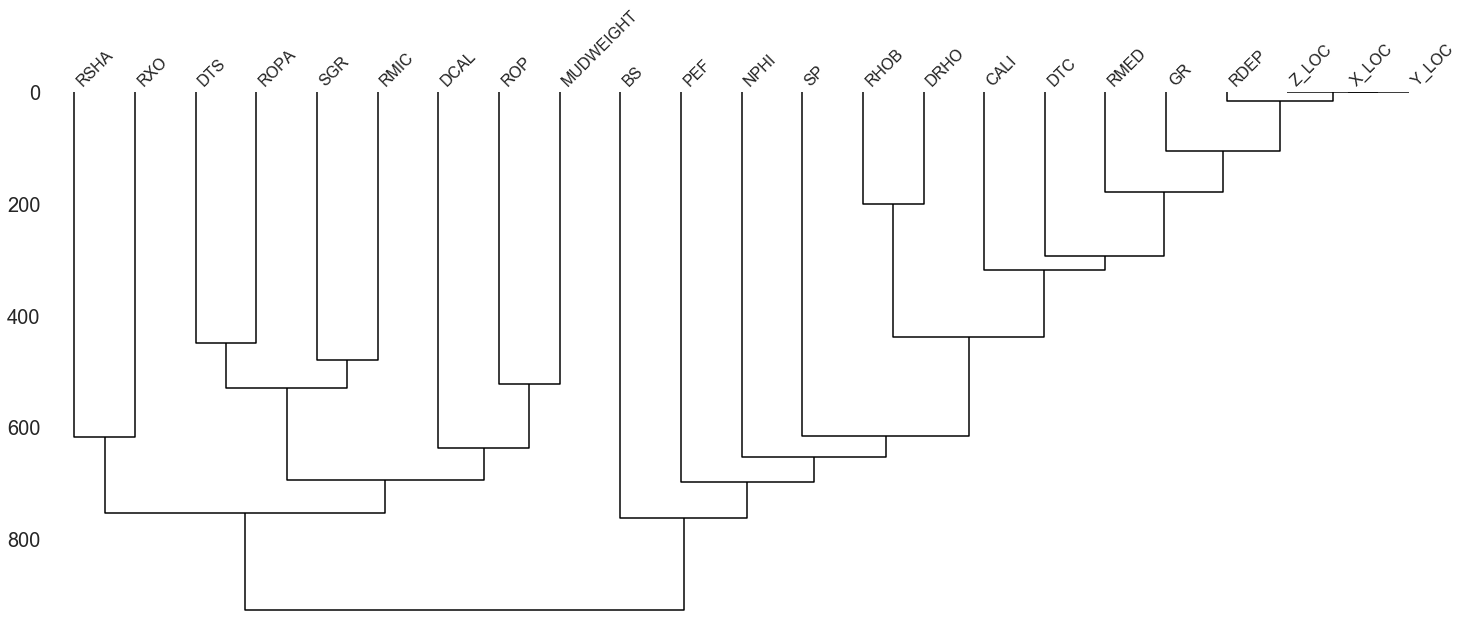

In [19]:
msno.dendrogram(X_all.drop(columns=['DEPTH_MD', 'GROUP', 'FORMATION']))

In [20]:
X_all.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI',
       'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP',
       'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO'],
      dtype='object')

In [21]:
# Some parameters
#'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS'
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED', 'RDEP', 'RHOB', 
                 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS']#
facies_names = lithology_keys.values()
facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
#
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [67]:
def data_modify(df):
  for col in ['RSHA', 'RMED', 'RDEP']:
    idx=df[df[col]<0].index
    df[col][df.index.isin(idx)]=np.nan
    idx=df[df[col]>2000].index
    df[col][df.index.isin(idx)]=2000
    df[col]=np.log10(df[col])  #convert all restivity logs to logarithmic scale
  for col in ['ROP']:
    idx=df[df[col]<=0].index
    df[col][df.index.isin(idx)]=np.nan
    df[col]=np.log10(df[col])   #convert all log to logarithmic scale
  for col in ['GR']:
    idx=df[df[col]>200].index
    df[col][df.index.isin(idx)]=200
#  for col in ['NPHI']:
#    idx=df[df[col]>0.6].index
#    df[col][df.index.isin(idx)]=np.nan#0.6
  return df

In [68]:
X=X_all[feature_names]
X=data_modify(X)
X.describe()#isna().sum()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,GR,RSHA,RMED,RDEP,RHOB,NPHI,PEF,DTC,DTS,SP,ROP,BS
count,1307297.00,1296463.00,1296463.00,1296463.00,1213775.00,1307297.00,669747.00,1267710.00,1296223.00,1129068.00,869452.00,785195.00,1225611.00,217833.00,930874.00,603322.00,749621.00
mean,2217.26,483759.47,6684114.86,-2165.87,13.12,70.07,0.26,0.25,0.24,2.29,0.33,6.29,112.87,200.83,58.85,1.17,11.84
std,1006.79,35122.31,129188.95,970.69,3.74,32.48,0.49,0.41,0.43,0.25,0.13,10.81,29.73,70.00,74.22,0.61,3.24
min,136.09,423237.53,6406641.00,-5395.56,2.34,0.11,-4.00,-1.40,-1.50,0.72,-0.04,0.10,7.42,69.16,-999.00,-2.64,6.00
25%,1443.35,454469.53,6591329.50,-2849.46,9.41,47.22,-0.07,-0.04,-0.04,2.09,0.24,3.39,87.74,153.72,32.25,0.80,8.50
50%,2113.33,476768.25,6737678.50,-2080.48,12.53,67.32,0.15,0.17,0.16,2.33,0.32,4.32,108.65,185.15,54.78,1.26,12.25
75%,2907.09,518963.34,6784907.50,-1416.13,16.35,88.54,0.49,0.43,0.41,2.49,0.42,6.00,140.26,220.40,80.22,1.53,12.25
max,5436.63,572632.75,6856661.00,-111.09,28.28,200.00,3.30,3.30,3.30,3.46,1.00,383.13,320.48,676.58,526.55,4.67,26.00


#### We should convert lithology labels to numbers 0-11 before training

In [24]:
Y = Alldata['FORCE_2020_LITHOFACIES_LITHOLOGY']
lithology_numbers = {} # initialize dictionary
lithology_numbers = {30000: 0,
                     65030: 1,
                     65000: 2,
                     80000: 3,
                     74000: 4,
                     70000: 5,
                     70032: 6,
                     88000: 7,
                     86000: 8,
                     99000: 9,
                     90000: 10,
                     93000: 11}
display(lithology_keys)
Y = Y.map(lithology_numbers)
Y.unique()

{30000: 'Sandstone',
 65030: 'Sandstone/Shale',
 65000: 'Shale',
 80000: 'Marl',
 74000: 'Dolomite',
 70000: 'Limestone',
 70032: 'Chalk',
 88000: 'Halite',
 86000: 'Anhydrite',
 99000: 'Tuff',
 90000: 'Coal',
 93000: 'Basement'}

array([ 2.,  0.,  1.,  5.,  9.,  3.,  8.,  4.,  6., 10.,  7., 11., nan])

In [111]:
# Store well labels and depths for training data
well = Alldata['WELL']
dataset = Alldata[['idx', 'Dataset']]
depth = Alldata['DEPTH_MD']
Strat = Alldata['GROUP']
Formation = Alldata['FORMATION']

In [112]:
# Sort data according to depth for each well
for w_idx, w in enumerate(np.unique(well)):
    X_well = X[well == w]
    X[well == w] = X_well.loc[depth[well == w].sort_values().index.values]
    depth[well == w] = np.sort(depth[well == w])
    
Y=Y.reindex(X.index)
Strat=Strat.reindex(X.index)
Formation=Formation.reindex(X.index)

In [113]:
#impute missing categorical values
def impute_nan(df, ds, dF):
    if ds.isnull().any()==True:
        labeler_st = LabelEncoder()
        rc_st = RidgeClassifier(tol=1e-2, solver="sag")
        Sg = Series(labeler_st.fit_transform(ds.astype(str)), index=ds.index)
        Sg = Sg.where(ds.notnull(), ds, axis=0)
        x_notna = df.GR[Sg.notnull()].to_numpy().reshape(-1, 1)
        y_notna = Sg[Sg.notnull()].to_numpy().astype('int').ravel()
        x_nan = df.GR[Sg.isnull()].to_numpy().reshape(-1, 1)
        rc_st.fit(x_notna,y_notna)
        Sg[Sg.isnull()]=rc_st.predict(x_nan)
        Sg=Series(Sg, index=ds.index).astype(int)
        ds=Series(labeler_st.inverse_transform(Sg.values.ravel()), index=ds.index)
        print('\nStratigraphy:', np.unique(ds))
    if dF.isnull().any()==True:
        labeler_fm = LabelEncoder()
        rc_fm = RidgeClassifier(tol=1e-2, solver="sag")
        Fm = Series(labeler_fm.fit_transform(dF.astype(str)), index=dF.index)
        Fm=Fm.where(dF.notnull(), dF, axis=0)
        x_notna = np.concatenate((df.GR[Fm.notnull()].to_numpy().reshape(-1, 1), 
                                  Sg[Fm.notnull()].to_numpy().reshape(-1, 1)), 
                                 axis=1)
        y_notna = Fm[Fm.notnull()].to_numpy().astype('int').ravel()
        x_nan = np.concatenate((df.GR[Fm.isnull()].to_numpy().reshape(-1, 1), 
                                Sg[Fm.isnull()].to_numpy().reshape(-1, 1)), axis=1)
        rc_fm.fit(x_notna,y_notna)
        Fm[Fm.isnull()]=rc_fm.predict(x_nan)
        Fm=Series(Fm, index=dF.index).astype(int)
        dF=Series(labeler_fm.inverse_transform(Fm.values.ravel()), index=dF.index)
        print('\nFormation:', np.unique(dF))
    return Sg, Fm

In [114]:
Sg, Fm = impute_nan(X, Strat, Formation)


Stratigraphy: ['BAAT GP.' 'BOKNFJORD GP.' 'CROMER KNOLL GP.' 'DUNLIN GP.' 'HEGRE GP.'
 'HORDALAND GP.' 'NORDLAND GP.' 'ROGALAND GP.' 'ROTLIEGENDES GP.'
 'SHETLAND GP.' 'TYNE GP.' 'VESTLAND GP.' 'VIKING GP.' 'ZECHSTEIN GP.']

Formation: ['Aasgard Fm.' 'Agat Fm.' 'Amundsen Fm.' 'BASEMENT' 'Balder Fm.'
 'Blodoeks Fm.' 'Broom Fm.' 'Bryne Fm.' 'Burton Fm.' 'Cook Fm.'
 'Drake Fm.' 'Draupne Fm.' 'Egersund Fm.' 'Eiriksson Mb.' 'Ekofisk Fm.'
 'Etive Fm.' 'Farsund Fm.' 'Fensfjord Fm.' 'Flekkefjord Fm.' 'Frigg Fm.'
 'Grid Fm.' 'Grid Mb.' 'Hardraade Fm.' 'Heather Fm.' 'Heimdal Fm.'
 'Hermod Mb.' 'Hidra Fm.' 'Hod Fm.' 'Hugin Fm.' 'Intra Balder Fm. Sst.'
 'Intra Draupne Fm. Sst.' 'Intra Heather Fm. Sst.' 'Johansen Fm.'
 'Jorsalfare Fm.' 'Krossfjord Fm.' 'Kupferschiefer Fm.' 'Kyrre Fm.'
 'Lista Fm.' 'Lunde Fm.' 'Mandal Fm.' 'Mime Fm.' 'Ness Fm.' 'Oseberg Fm.'
 'Ran Sst Mb.' 'Rannoch Fm.' 'Raude Mb.' 'Roedby Fm.' 'Sandnes Fm.'
 'Sauda Fm.' 'Sele Fm.' 'Skade Fm.' 'Skade Mb.' 'Skagerrak Fm.'
 'Sleipner

##### As an approach, we replace nan values by modeling each feature with missing values as a function of other features in a round-robin fashion

In [29]:
from scipy.ndimage import median_filter

#%% Remove noise from the data
def apply_filter(df):
    df = df.apply(lambda x: median_filter(x,size=40,mode='nearest'))
    return df

def apply_filternp(df):
    for i in range(df.shape[1]):
        df[i]=median_filter(df[i],size=5,mode='nearest')
    return df

In [145]:
#Zero imputer
X_imp=X.fillna(0)
X_imp.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,GR,RSHA,RMED,RDEP,RHOB,NPHI,PEF,DTC,DTS,SP,ROP,BS
count,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00,1307297.00
mean,2217.26,479750.39,6628721.40,-2147.92,12.19,70.07,0.13,0.24,0.24,1.98,0.22,3.78,105.82,33.46,41.91,0.54,6.79
std,1006.79,56095.54,619467.15,986.40,4.95,32.48,0.37,0.40,0.43,0.82,0.19,8.93,39.69,80.11,68.06,0.72,6.35
min,136.09,0.00,0.00,-5395.56,0.00,0.11,-4.00,-1.40,-1.50,0.00,-0.04,0.00,0.00,0.00,-999.00,-2.64,0.00
25%,1443.35,454469.53,6590892.50,-2843.06,8.87,47.22,0.00,-0.03,-0.04,2.01,0.00,0.00,84.06,0.00,0.00,0.00,0.00
50%,2113.33,476768.16,6737676.00,-2068.50,12.43,67.32,0.00,0.15,0.16,2.25,0.24,3.06,104.94,0.00,36.90,0.00,8.50
75%,2907.09,518365.59,6784906.00,-1399.02,15.46,88.54,0.16,0.42,0.41,2.47,0.36,4.73,138.92,0.00,67.25,1.21,12.25
max,5436.63,572632.75,6856661.00,0.00,28.28,200.00,3.30,3.30,3.30,3.46,1.00,383.13,320.48,676.58,526.55,4.67,26.00


In [34]:
#Now define a function that creates a plot with log curves, as well as a lithofacies track. 
#This plot will be flexible, in that we can provide a list of curve mnemonics that 
#we want to include in the plot.

def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)    
    

def compare_facies_plot(logs, well_name, facies_name, facies_colors, vmax):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['litho_real'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['litho_pred'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.RDEP, logs.Depth, '-b')
    ax[2].plot(logs.NPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.Depth, '-', color='r')
    ax[4].plot(logs.PEF, logs.Depth, '-', color='black')
    ax[5].plot(logs.DTC, logs.Depth, '-', color='m')
    im1 = ax[6].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    im2 = ax[7].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((55*' ').join(facies_name))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("RDEP")
    ax[1].set_xlim(logs.RDEP.min(),logs.RDEP.max())
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("PEF")
    ax[4].set_xlim(logs.PEF.min(),logs.PEF.max())
    ax[5].set_xlabel("DTC")
    ax[5].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[6].set_xlabel('litho_real')
    ax[7].set_xlabel('litho_pred')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([]); ax[7].set_yticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94)    

def display_cm(cm, labels, hide_zeros=False,
                             display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """

    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=' ')
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=' ')
    print("%{0}s".format(columnwidth) % 'Total')
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=' ')
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
    if display_metrics:
        print()
        print("Precision", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_precision)
        print("   Recall", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_recall)
        print("       F1", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_F1)

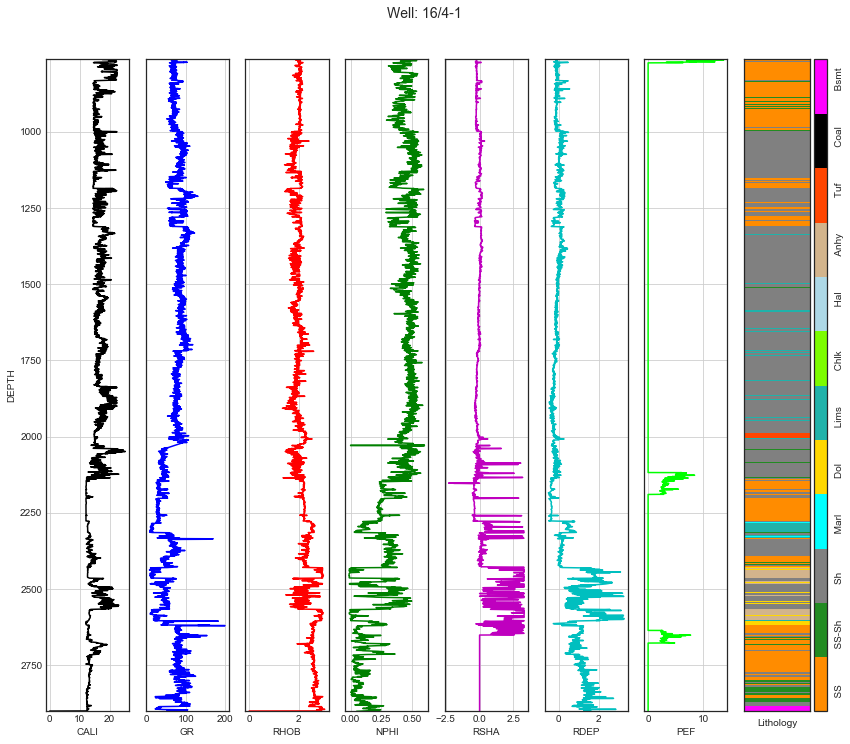

In [35]:
well_no=13
logs = pd.concat([X_imp, 
                  Y], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_wells[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI', 'RSHA', 'RDEP', 'PEF'],
                     train_wells[well_no],
                     facies_colors)

In [146]:
def combine_features(df, formation, strat):
    df=pd.concat([df, formation, strat], axis=1).rename(columns = {0:'Formation', 1:'Strata'})
    
    return df

In [147]:
X_imp=combine_features(X_imp, Fm, Sg)
X_imp.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED',
       'RDEP', 'RHOB', 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS',
       'Formation', 'Strata'],
      dtype='object')

### Feature Engineering

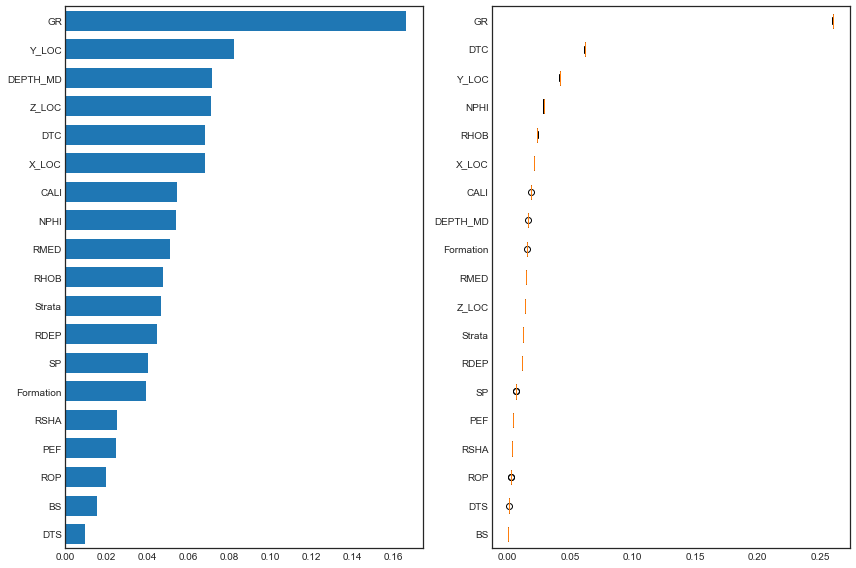

In [146]:
df_labels=Y[Alldata.Dataset=='Train']
df_features = X_imp[Alldata.Dataset=='Train']
from sklearn.inspection import permutation_importance

mod = RandomForestClassifier(n_estimators=50, random_state=seed_value)
mod.fit(df_features, df_labels)

result = permutation_importance(mod, df_features, df_labels, n_repeats=10,
                                random_state=seed_value)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(mod.feature_importances_)
tree_indices = np.arange(0, len(mod.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         mod.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(df_features.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(mod.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=df_features.columns[perm_sorted_idx])
fig.tight_layout()

In [38]:
#can we make new features by combining previous ones?
import featuretools as ft
df_features = X_imp[Alldata.Dataset=='Train']
es = ft.EntitySet(id = 'observations')
es = es.entity_from_dataframe(entity_id = 'observations', dataframe = df_features.reset_index(), 
                              index = 'index',
                              variable_types={"Formation": ft.variable_types.Categorical,
                                              "Strata": ft.variable_types.Categorical})
features, ft_names = ft.dfs(entityset = es, target_entity = 'observations', 
                            trans_primitives = ['multiply_numeric'],
                            #trans_primitives = ['add_numeric', 'multiply_numeric', 
                            #                    'subtract_numeric', 'divide_numeric', 'diff'],
                            max_depth=2)
features.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED',
       'RDEP', 'RHOB',
       ...
       'RSHA * SP', 'RSHA * X_LOC', 'RSHA * Y_LOC', 'RSHA * Z_LOC',
       'SP * X_LOC', 'SP * Y_LOC', 'SP * Z_LOC', 'X_LOC * Y_LOC',
       'X_LOC * Z_LOC', 'Y_LOC * Z_LOC'],
      dtype='object', length=155)

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED',
       'RDEP', 'RHOB', 'NPHI', 'PEF', 'DTC', 'SP', 'ROP', 'BS', 'Formation',
       'Strata', 'BS * DEPTH_MD', 'BS * DTC', 'BS * GR', 'BS * NPHI',
       'BS * PEF', 'BS * RHOB', 'BS * ROP', 'BS * RSHA', 'BS * SP',
       'BS * X_LOC', 'BS * Y_LOC', 'BS * Z_LOC', 'CALI * DEPTH_MD',
       'CALI * GR', 'CALI * RHOB', 'CALI * ROP', 'CALI * RSHA', 'CALI * Z_LOC',
       'DEPTH_MD * DTC', 'DEPTH_MD * GR', 'DEPTH_MD * NPHI', 'DEPTH_MD * PEF',
       'DEPTH_MD * RDEP', 'DEPTH_MD * ROP', 'DEPTH_MD * RSHA', 'DEPTH_MD * SP',
       'DTC * GR', 'DTC * NPHI', 'DTC * PEF', 'DTC * RHOB', 'DTC * ROP',
       'DTC * SP', 'DTC * Z_LOC', 'GR * PEF', 'GR * RDEP', 'GR * RHOB',
       'GR * ROP', 'GR * RSHA', 'GR * SP', 'GR * Z_LOC', 'NPHI * RHOB',
       'NPHI * ROP', 'NPHI * Z_LOC', 'PEF * RDEP', 'PEF * RHOB', 'PEF * ROP',
       'PEF * RSHA', 'PEF * SP', 'PEF * Z_LOC', 'RDEP * RMED', 'RDEP * SP',
       'RDEP * Z_LOC', 'RHOB * 

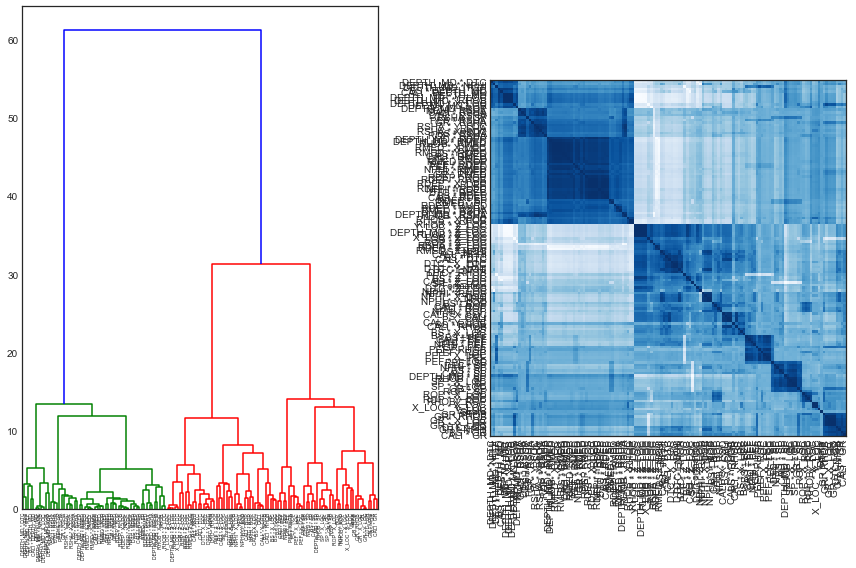

In [133]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

df=features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(df).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=df.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']], cmap=plt.cm.Blues)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()

from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
df.iloc[:, selected_features].columns

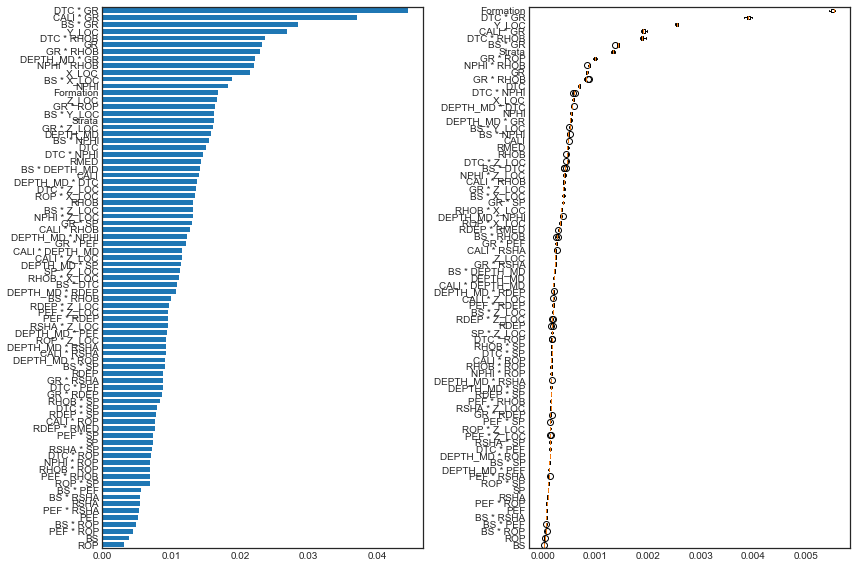

In [134]:
df_labels=Y[Alldata.Dataset=='Train']
df_features = features.iloc[:, selected_features]
from sklearn.inspection import permutation_importance

mod = RandomForestClassifier(n_estimators=50, random_state=seed_value)
mod.fit(df_features, df_labels)

result = permutation_importance(mod, df_features, df_labels, n_repeats=10,
                                random_state=seed_value)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(mod.feature_importances_)
tree_indices = np.arange(0, len(mod.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         mod.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(df_features.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(mod.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=df_features.columns[perm_sorted_idx])
fig.tight_layout()

### Feature selection and augmentation

In [39]:
# Feature augmentation function
def augment_features(X, well, depth):
    
    # Augment features
    padded_rows = []
    X_aug = np.zeros((X.shape[0], X.shape[1]*2))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]  #index
        
        # Compute features gradient function
        d_diff = np.diff(depth[w_idx]).reshape((-1, 1)) #check difference in depth
        d_diff[d_diff==0] = 0.01                        #if difference in depth is zero, make it 0.01
        X_diff = np.diff(X.loc[w_idx, :], axis=0)           #check difference in features
        X_grad = X_diff / d_diff                        #calculate gradient by dividing features by depth 
        
        # Compensate for last rows - padding
        X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
        X_aug[w_idx, :] = np.concatenate((X.loc[w_idx, :], X_grad), axis=1)
        
        # Find padded rows
        padded_rows.append(w_idx[-1])
                    
    return X_aug, padded_rows

In [148]:
# Augment features
to_drop=['DTS', 'ROP', 'BS']#, 'CALIBS', 'RMED', 'DTC', 'SP'
X_impd=X_imp.drop(to_drop, axis=1)
X_aug, padded_rows = augment_features(X_impd, well, depth)
col=list(X_impd.columns.values)
col= col + ['Delta' + sub for sub in col]
X_aug = DataFrame(X_aug, index=X_impd.index, columns=col)
len(padded_rows)
X_aug.shape

(1307297, 32)

### Applying the custom scoring function

Apart from the missing log curves, **one of the key challenges of this machine learning competition is that you are being scored using a custom scoring function**. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

In [42]:
A = np.load('D:/.jupyter/Machine_Predicted_Lithology/penalty_matrix.npy')

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [43]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

**IMPORTANT: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.**

#### Select only the columns you want to use

In [149]:
Xtrain=X_aug[Alldata.Dataset=='Train']
Ytrain=Y[Alldata.Dataset=='Train']

Test_idx=Alldata.idx.reindex(X.index)[data.index.max()+1:,]
Xtest=X_aug[Alldata.Dataset=='Test'].set_index(Test_idx).reindex(data_test.index)
Xtest

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,GR,RSHA,RMED,RDEP,RHOB,NPHI,PEF,DTC,SP,Formation,Strata,DeltaDEPTH_MD,DeltaX_LOC,DeltaY_LOC,DeltaZ_LOC,DeltaCALI,DeltaGR,DeltaRSHA,DeltaRMED,DeltaRDEP,DeltaRHOB,DeltaNPHI,DeltaPEF,DeltaDTC,DeltaSP,DeltaFormation,DeltaStrata
0,480.63,423244.50,6461862.50,-455.62,19.20,72.08,0.00,0.21,0.18,2.17,0.55,55.82,174.35,35.53,67.00,6.00,1.00,0.00,0.00,-1.00,0.00,0.46,0.00,-0.07,-0.06,0.00,-0.03,-91.80,11.62,4.16,0.00,0.00
1,480.78,423244.50,6461862.50,-455.78,19.20,72.15,0.00,0.20,0.17,2.17,0.55,41.86,176.11,36.16,67.00,6.00,1.00,0.00,0.00,-1.00,0.00,19.25,0.00,-0.26,-0.02,-0.07,0.03,-21.54,10.19,4.71,0.00,0.00
2,480.93,423244.50,6461862.50,-455.93,19.20,75.07,0.00,0.16,0.17,2.16,0.55,38.59,177.66,36.87,67.00,6.00,1.00,0.00,0.00,-1.00,0.00,37.24,0.00,-0.34,-0.00,-0.06,0.00,18.62,-1.48,2.83,0.00,0.00
3,481.08,423244.50,6461862.50,-456.08,19.20,80.74,0.00,0.11,0.17,2.15,0.55,41.42,177.44,37.30,67.00,6.00,1.00,0.21,0.00,-1.00,0.00,6.12,0.00,-0.16,-0.01,-0.06,0.09,52.98,-4.21,3.69,0.00,0.00
4,481.24,423244.53,6461862.50,-456.23,19.20,81.67,0.00,0.08,0.17,2.14,0.57,49.47,176.80,37.86,67.00,6.00,1.00,0.00,0.00,-1.00,0.00,-7.10,0.00,0.09,-0.01,-0.12,-0.02,17.13,-10.57,-1.54,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,3224.39,536225.94,6794880.50,-3199.88,8.50,60.64,0.00,0.79,0.85,2.58,0.18,5.58,67.79,0.00,44.00,0.00,1.00,0.00,0.00,-1.00,0.00,-2.15,0.00,-0.09,-0.06,-0.03,0.01,-0.32,0.69,0.00,0.00,0.00
136782,3224.54,536225.94,6794880.50,-3200.03,8.50,60.32,0.00,0.78,0.84,2.58,0.18,5.53,67.90,0.00,44.00,0.00,1.00,0.00,0.00,-1.00,0.00,23.62,0.00,-0.26,-0.23,0.00,0.01,-5.04,2.12,0.00,0.00,0.00
136783,3224.69,536225.94,6794880.50,-3200.18,8.50,63.91,0.00,0.74,0.80,2.58,0.18,4.77,68.22,0.00,44.00,0.00,1.00,0.00,0.00,-1.00,0.00,4.37,0.00,-0.33,-0.32,-0.07,0.01,-0.29,3.18,0.00,0.00,0.00
136784,3224.85,536225.94,6794880.50,-3200.33,8.50,64.57,0.00,0.69,0.75,2.57,0.18,4.72,68.70,0.00,44.00,0.00,1.00,0.00,0.00,-1.00,0.00,35.05,0.00,-0.20,-0.21,-0.10,0.00,-0.23,4.26,0.00,0.00,0.00


In [150]:
X_nopad = Xtrain[~Xtrain.index.isin(padded_rows)]
Y_nopad = Ytrain[~Ytrain.index.isin(padded_rows)]

# Remove a single well to use as a blind test later
X_blind = X_nopad[well == '7/1-2 S']
Y_blind = Y_nopad[well == '7/1-2 S']

X_nopad = X_nopad[well != '7/1-2 S']
Y_nopad = Y_nopad[well != '7/1-2 S']
X_blind.shape

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(2039, 32)

##### Shuffle the data

In [151]:
X_s, Y_s = DataFrame([]), DataFrame([])
X_sh, Y_sh = DataFrame([]), DataFrame([])
for w in train_wells:
    Xsh, Ysh = shuffle(X_nopad[well == w], Y_nopad[well == w], random_state=seed_value)
    X_s = pd.concat([X_s, Xsh], axis=0, sort=False)
    Y_s = pd.concat([Y_s, Ysh], axis=0, sort=False)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


##### Scale the features

In [152]:
scaler = StandardScaler()
#scaler = RobustScaler(quantile_range=(25.0, 75.0))

In [153]:
X_s = DataFrame(scaler.fit_transform(X_s), index=X_s.index, columns=X_s.columns)

##### Split into train and test data

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(X_s, Y_s, test_size=0.1, random_state=seed_value)
Y_train=Y_train.to_numpy().ravel()
X_train=X_train.to_numpy()

In [100]:
# Train classifier
grid = {'learning_rate': [0.01, 0.05, 0.1], 
        'num_iterations': [300, 500, 700], 
        'bagging_fraction': [0.8, 0.9, 1.0], 
        'feature_fraction': [0.3, 0.4, 0.6], 
        'num_leaves': [100, 120, 150],
        #'reg_alpha': [0.2, 0.5, 1, 1.2], 
        #'subsample' : [0.7, 0.75, 0.9],
        #'colsample_bytree' : [0.5, 0.65, 0.8, 0.9],
        #'class_weight' : ['balanced', None],
        'max_depth': [10, 15, 30]}

modelgbm = lgbm.LGBMClassifier(random_state=seed_value, class_weight= None, objective = 'multiclass', 
                               num_class = 12, silent='False')
model = RandomizedSearchCV(estimator=modelgbm, param_distributions=grid,
                           scoring=make_scorer(score, greater_is_better=True), n_iter=100,
                           cv=KFold(n_splits=5, shuffle=True, random_state=seed_value),
                           random_state=seed_value, verbose=5)
model.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.310, total= 3.0min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.508, total= 3.1min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.236, total= 3.3min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.5min remaining:    0.0s
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.517, total= 3.1min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.377, total= 3.4min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.462, total= 4.0min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.707, total= 4.3min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.479, total= 4.1min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.514, total= 4.1min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.168, total= 4.5min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.402, total= 4.3min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.275, total= 4.6min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.286, total= 4.5min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.307, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.329, total= 4.2min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.193, total= 4.8min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.192, total= 5.3min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.189, total= 5.4min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.191, total= 5.2min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.192, total= 4.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.220, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.222, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.217, total= 2.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.216, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.222, total= 3.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.277, total= 4.9min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.276, total= 5.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.275, total= 5.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.273, total= 5.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.276, total= 4.9min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.416, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.202, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.241, total= 2.6min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.225, total= 2.5min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.265, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.337, total= 2.9min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.337, total= 2.9min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.334, total= 2.9min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.332, total= 2.9min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.338, total= 2.9min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.175, total= 6.3min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.174, total= 6.2min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.170, total= 6.3min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.172, total= 6.3min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.174, total= 6.2min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.331, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.330, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.329, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.326, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.330, total= 2.8min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.304, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.305, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.302, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.300, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.304, total= 3.3min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.570, total= 5.4min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.691, total= 5.7min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.612, total= 6.0min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.818, total= 6.2min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.654, total= 5.7min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.645, total= 4.9min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-1.664, total= 4.0min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.452, total= 5.3min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.374, total= 5.3min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.316, total= 5.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.270, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.231, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.267, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.206, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.274, total= 3.8min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.181, total= 7.5min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.220, total= 8.1min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.712, total= 7.9min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.593, total= 7.3min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.263, total= 8.0min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.271, total= 5.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.271, total= 5.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.268, total= 5.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.266, total= 5.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.271, total= 5.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.348, total= 4.9min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.481, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.620, total= 4.5min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.658, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.398, total= 6.0min
[CV] num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.225, total= 6.2min
[CV] num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.193, total= 5.7min
[CV] num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.189, total= 5.7min
[CV] num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.189, total= 5.6min
[CV] num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.195, total= 5.6min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.304, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.305, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.302, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.300, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.304, total= 3.3min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.212, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.210, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.208, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.209, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.210, total= 3.0min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.885, total= 3.8min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.170, total= 4.4min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.168, total= 4.3min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.760, total= 4.5min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-1.077, total= 3.2min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.241, total= 9.6min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.239, total= 9.6min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.236, total= 9.6min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.235, total= 9.7min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.240, total= 9.6min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.323, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.324, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.322, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.318, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.323, total= 3.0min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.604, total= 6.1min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.399, total= 7.5min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.611, total= 6.3min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.492, total= 6.1min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.622, total= 6.5min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.293, total= 4.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.202, total= 3.9min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.200, total= 3.9min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.222, total= 4.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.203, total= 4.0min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.601, total= 4.1min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.791, total= 4.5min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.386, total= 4.7min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.733, total= 4.9min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.614, total= 4.6min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.350, total= 2.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.217, total= 2.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.217, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.211, total= 2.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.292, total= 2.8min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.273, total= 4.3min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.205, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.199, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.202, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.204, total= 4.2min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.530, total= 6.2min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.651, total= 6.3min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-1.580, total= 5.2min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.523, total= 6.3min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.507, total= 6.9min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.196, total= 4.6min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.195, total= 4.5min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.192, total= 4.6min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.193, total= 4.5min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.196, total= 4.5min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.276, total= 5.2min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.277, total= 5.3min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.274, total= 5.2min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.272, total= 5.3min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.276, total= 5.2min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.265, total= 6.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.266, total= 6.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.263, total= 6.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.262, total= 6.7min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.266, total= 6.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.244, total= 2.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.235, total= 2.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.345, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.244, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.231, total= 2.5min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.225, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.250, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.360, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.216, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.192, total= 2.8min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.181, total= 7.7min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.220, total= 8.2min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.712, total= 8.1min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.593, total= 7.3min
[CV] num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.263, total= 8.1min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.293, total= 6.6min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-1.251, total= 7.3min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.288, total= 7.3min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.215, total= 8.2min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.827, total= 7.5min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.181, total= 7.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.181, total= 6.0min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.178, total= 6.3min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.179, total= 6.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.181, total= 6.0min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.304, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.305, total= 3.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.302, total= 3.4min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.300, total= 3.2min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.304, total= 3.2min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.338, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.338, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.337, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.334, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.339, total= 2.8min
[CV] num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.628, total= 4.5min
[CV] num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.470, total= 4.5min
[CV] num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.260, total= 5.2min
[CV] num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-1.874, total= 3.2min
[CV] num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.828, total= 3.7min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.186, total= 5.3min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.185, total= 5.5min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.181, total= 5.4min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.202, total= 5.4min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.186, total= 5.3min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.680, total= 4.5min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.475, total= 5.0min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.377, total= 5.9min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.558, total= 5.2min
[CV] num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-1.183, total= 3.5min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.273, total= 6.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.274, total= 6.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.270, total= 6.1min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.270, total= 6.3min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.272, total= 6.2min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0, score=-0.316, total= 3.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0, score=-0.316, total= 3.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0, score=-0.313, total= 3.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0, score=-0.311, total= 3.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=1.0, score=-0.314, total= 3.7min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.267, total= 7.8min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.223, total= 8.3min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.350, total= 7.2min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.172, total= 7.7min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.445, total= 6.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9, score=-0.193, total= 4.6min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9, score=-0.240, total= 4.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9, score=-0.191, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9, score=-0.267, total= 4.8min
[CV] num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.9, score=-0.195, total= 4.7min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.253, total= 6.7min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.253, total= 6.8min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.250, total= 6.7min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.249, total= 6.8min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.253, total= 6.7min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.267, total= 5.7min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.232, total= 6.1min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.358, total= 5.6min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.185, total= 5.8min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.469, total= 5.4min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.245, total= 3.5min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.499, total= 3.2min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.499, total= 3.3min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.178, total= 3.3min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.596, total= 3.3min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.233, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.231, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.227, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.227, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=1.0, score=-0.231, total= 2.4min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.308, total= 3.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.317, total= 3.8min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.463, total= 3.9min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.199, total= 4.0min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.575, total= 4.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.219, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.217, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.214, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.214, total= 2.9min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.216, total= 2.8min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.293, total= 5.5min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-1.251, total= 5.5min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.288, total= 5.2min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.215, total= 5.5min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.827, total= 5.3min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.194, total= 5.5min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.234, total= 5.7min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.226, total= 5.7min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.612, total= 5.4min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.267, total= 5.6min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.270, total= 4.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.191, total= 4.0min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.188, total= 4.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.230, total= 4.2min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.191, total= 4.1min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.240, total= 7.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.239, total= 7.7min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.236, total= 7.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.236, total= 7.7min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.240, total= 7.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.251, total= 8.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.250, total= 8.5min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.247, total= 8.5min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.247, total= 8.5min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.251, total= 8.7min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.332, total= 8.6min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.221, total= 8.3min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.224, total= 8.4min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.316, total= 8.0min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.170, total= 8.0min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.272, total= 9.2min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.162, total= 8.4min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.159, total= 8.5min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.218, total= 9.2min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.162, total= 8.4min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.271, total= 3.5min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.235, total= 3.7min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.236, total= 3.9min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.269, total= 3.7min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.201, total= 3.8min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.617, total= 6.6min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.633, total= 7.1min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.517, total= 7.3min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-0.715, total= 6.6min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=1.0, score=-1.052, total= 5.0min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.280, total= 8.0min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.217, total= 7.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.174, total= 7.1min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.212, total= 7.6min
[CV] num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=700, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.8, score=-0.550, total= 7.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.807, total= 2.8min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.217, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.254, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.551, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.276, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.429, total= 3.5min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.320, total= 3.7min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.601, total= 3.9min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.502, total= 3.6min
[CV] num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-1.184, total= 3.5min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.316, total= 3.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.316, total= 3.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.313, total= 3.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.311, total= 3.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.314, total= 3.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.240, total= 7.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.239, total= 7.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.236, total= 7.5min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.236, total= 7.6min
[CV] num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.240, total= 7.6min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.203, total= 2.3min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.283, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.223, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.306, total= 2.4min
[CV] num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.476, total= 2.2min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.374, total= 2.4min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.188, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.187, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.220, total= 2.7min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-1.145, total= 2.5min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.418, total= 4.2min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.382, total= 4.2min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-1.240, total= 3.8min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.460, total= 4.4min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.8, score=-0.451, total= 4.1min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.197, total= 4.2min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.194, total= 4.2min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.190, total= 4.2min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.254, total= 4.5min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.196, total= 4.3min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.172, total= 3.6min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.441, total= 3.6min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.572, total= 3.7min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.410, total= 3.6min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.9, score=-0.505, total= 3.5min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.234, total= 3.5min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.239, total= 3.5min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.209, total= 3.4min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.231, total= 3.5min
[CV] num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=30, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.212, total= 3.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.337, total= 2.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.337, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.334, total= 2.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.332, total= 2.7min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.338, total= 2.8min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.253, total= 7.1min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.253, total= 7.0min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.249, total= 7.0min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.249, total= 7.0min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.252, total= 7.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.326, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.326, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.322, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.321, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.326, total= 3.0min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.270, total= 6.5min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.270, total= 6.6min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.266, total= 6.7min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.265, total= 6.7min
[CV] num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.269, total= 6.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.277, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.276, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.275, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.273, total= 4.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, score=-0.276, total= 4.7min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.570, total= 5.1min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.691, total= 5.5min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.612, total= 5.8min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.818, total= 6.0min
[CV] num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=10, learning_rate=0.1, feature_fraction=0.6, bagging_fraction=0.8, score=-0.654, total= 5.5min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.226, total= 2.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.224, total= 2.8min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.222, total= 3.3min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.222, total= 2.6min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.225, total= 2.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.296, total= 8.2min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.171, total= 7.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.167, total= 7.6min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.214, total= 8.2min
[CV] num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.171, total= 7.7min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.265, total= 6.1min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.265, total= 6.1min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.263, total= 6.1min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.262, total= 6.2min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=1.0, score=-0.266, total= 6.0min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.235, total= 3.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.234, total= 3.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.302, total= 3.2min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.229, total= 3.4min
[CV] num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=0.9, score=-0.221, total= 3.3min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.169, total= 6.5min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.167, total= 6.6min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.165, total= 6.5min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.165, total= 6.6min
[CV] num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=700, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.9, score=-0.168, total= 6.5min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.346, total= 2.7min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.347, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.345, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.342, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.348, total= 2.7min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.290, total= 4.3min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.290, total= 4.3min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.288, total= 4.6min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.286, total= 4.4min
[CV] num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=500, max_depth=30, learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.9, score=-0.290, total= 4.3min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.321, total= 4.0min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.330, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.390, total= 3.6min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.323, total= 3.7min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=0.9, score=-0.264, total= 3.9min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.287, total= 4.6min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.287, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.285, total= 4.6min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.283, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=1.0, score=-0.287, total= 4.6min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.196, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.195, total= 4.3min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.192, total= 4.2min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.193, total= 4.3min
[CV] num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=0.8, score=-0.196, total= 4.3min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.227, total= 4.4min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.207, total= 4.0min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.204, total= 4.0min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.204, total= 4.0min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.05, feature_fraction=0.3, bagging_fraction=0.8, score=-0.209, total= 4.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0, score=-0.212, total= 2.9min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0, score=-0.210, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0, score=-0.208, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0, score=-0.209, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.05, feature_fraction=0.4, bagging_fraction=1.0, score=-0.210, total= 2.9min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.270, total= 3.5min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.231, total= 3.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.267, total= 3.7min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.206, total= 3.6min
[CV] num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=10, learning_rate=0.05, feature_fraction=0.6, bagging_fraction=1.0, score=-0.274, total= 3.5min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.298, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.298, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.297, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.294, total= 3.8min
[CV] num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=30, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.9, score=-0.297, total= 3.7min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.318, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.319, total= 2.9min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.316, total= 2.9min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.314, total= 3.0min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.319, total= 3.0min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.807, total= 2.8min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.217, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.254, total= 3.1min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.551, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.9, score=-0.276, total= 3.0min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.279, total= 6.1min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.279, total= 6.1min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.276, total= 6.3min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.275, total= 6.2min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.6, bagging_fraction=0.8, score=-0.278, total= 6.1min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.252, total= 7.0min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.252, total= 6.9min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.249, total= 6.9min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.248, total= 7.0min
[CV] num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=700, max_depth=30, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.9, score=-0.252, total= 7.1min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.390, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.638, total= 2.8min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.383, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.337, total= 2.6min
[CV] num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=120, num_iterations=300, max_depth=15, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=1.0, score=-0.186, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0, score=-0.350, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0, score=-0.217, total= 2.8min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0, score=-0.217, total= 2.7min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0, score=-0.211, total= 2.8min
[CV] num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=300, max_depth=10, learning_rate=0.1, feature_fraction=0.3, bagging_fraction=1.0, score=-0.292, total= 2.7min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.767, total= 4.2min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.714, total= 5.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.503, total= 5.1min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.789, total= 4.0min
[CV] num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=150, num_iterations=500, max_depth=30, learning_rate=0.1, feature_fraction=0.4, bagging_fraction=0.8, score=-0.466, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.292, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.292, total= 4.8min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.290, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.287, total= 4.7min
[CV] num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8 


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  num_leaves=100, num_iterations=500, max_depth=10, learning_rate=0.01, feature_fraction=0.4, bagging_fraction=0.8, score=-0.292, total= 4.7min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 2361.9min finished
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=12, num_leaves=31,
                                            objectiv...
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
            

In [107]:
display(model.best_params_)
result=DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index()
display(result.head(5))
param=model.best_params_  #result.loc[0, 'params']

{'num_leaves': 150,
 'num_iterations': 700,
 'max_depth': 15,
 'learning_rate': 0.05,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.9}

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,82,304.76,2.37,87.35,0.28,150,700,15,0.05,0.40,0.90,"{'num_leaves': 150, 'num_iterations': 700, 'ma...",-0.17,-0.17,-0.16,-0.16,-0.17,-0.17,0.00,1
1,8,292.61,1.92,81.95,0.30,120,700,30,0.05,0.40,0.80,"{'num_leaves': 120, 'num_iterations': 700, 'ma...",-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,0.00,2
2,36,303.94,35.22,84.47,6.07,100,700,30,0.05,0.40,0.90,"{'num_leaves': 100, 'num_iterations': 700, 'ma...",-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,0.00,3
3,40,248.19,3.11,74.67,2.53,150,500,10,0.05,0.40,0.90,"{'num_leaves': 150, 'num_iterations': 500, 'ma...",-0.19,-0.18,-0.18,-0.20,-0.19,-0.19,0.01,4
4,3,234.27,10.85,72.29,3.29,120,500,10,0.05,0.40,0.90,"{'num_leaves': 120, 'num_iterations': 500, 'ma...",-0.19,-0.19,-0.19,-0.19,-0.19,-0.19,0.00,5


In [155]:
param = {'num_leaves': 150, #120,
         'num_iterations': 500, #400,
         'max_depth': 15,
         'learning_rate': 0.05,
         'feature_fraction': 0.4, #0.5,
         'class_weight': None,
         'bagging_fraction': 0.9 #0.8
        }

model = lgbm.LGBMClassifier(learning_rate=param['learning_rate'], max_depth=param['max_depth'],
                               num_leaves=param['num_leaves'], num_iterations=param['num_iterations'], 
                               feature_fraction=param['feature_fraction'], class_weight= None, #param['class_weight']
                               bagging_fraction=param['bagging_fraction'], silent='False',
                               random_state=seed_value, objective = 'multiclass', num_class = 12)
model.fit(X_train, Y_train)#, sample_weight=dw

D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_class=12, num_iterations=500, num_leaves=150,
               objective='multiclass', random_state=42, silent='False')

In [156]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

#### Test model

In [157]:
Y_pred = model.predict(X_test.to_numpy())

In [158]:
score(Y_test.values, Y_pred)

array([-0.17014156])

In [159]:
conf_mat=confusion_matrix(Y_test.values, Y_pred)
facies_labels = ['SS', 'SS-Sh', 'Sh', ' Marl', 'Dol', 'Lims', 'Chlk ', 'Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']
display_cm(conf_mat, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS SS-Sh    Sh  Marl   Dol  Lims Chlk    Hal  Anhy   Tuf  Coal  Bsmt Total
     True
       SS 15474   703   652     6          48                 1     6    13       16903
    SS-Sh   827 12186  1848    18     3    48                       2     6       14938
       Sh   395   853 70284   133    14   167           1     1    40    17     2 71907
     Marl     7    15   159  3045     1   117    11                             1  3356
      Dol     6    10    72     2    72    11                 1     3               177
     Lims   131   129   651   117     4  4585    17           2    22              5658
    Chlk                        6          24  1014                                1044
      Hal                 1                           832                           833
     Anhy                 5                 1           6   112                     124
      Tuf     1          47                 3                    1446              1497
     Coal    24     7 

In [160]:
X_blind2 = DataFrame(scaler.transform(X_blind), index=X_blind.index, columns=X_blind.columns)
Y_blind_pred = model.predict(X_blind2.to_numpy())
score(Y_blind.values, Y_blind_pred)

-0.24123344776851396

In [161]:
conf_mat=confusion_matrix(Y_blind.values, Y_blind_pred)
facies_labels_blind = [facies_labels[np.sort(Y_blind.astype(int).unique())[i]] for i in np.sort(Y_blind.unique()).astype(int)]
display_cm(conf_mat, facies_labels_blind, display_metrics=True, hide_zeros=True)

     Pred    SS SS-Sh    Sh Total
     True
       SS  1319    34    17  1375
    SS-Sh    29    75   106   212
       Sh     1    11   440   452

Precision  0.98  0.62  0.78  0.90
   Recall  0.96  0.35  0.97  0.90
       F1  0.97  0.45  0.87  0.89


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


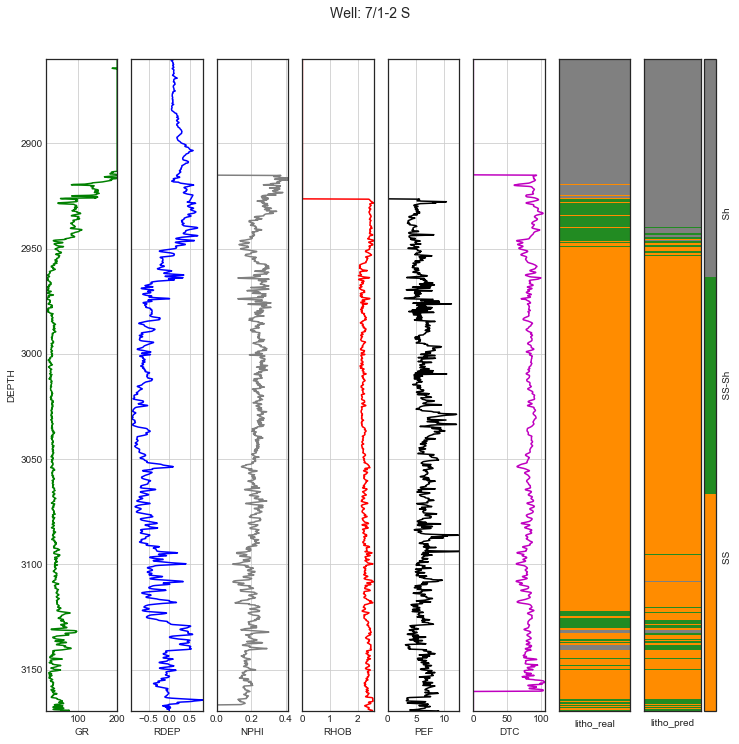

In [162]:
logs = pd.concat([X_blind.iloc[:,:len(X_imp.columns)], #depth[well =='7/1-2 S'], 
                  Y_blind], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'})
logs = pd.concat([logs, Series(Y_blind_pred, index=Y_blind.index)], axis=1).rename(columns = {0:'litho_pred'})
facies_colors_blind = [facies_colors[int(np.unique(Y_blind)[i])] for i in range(np.unique(Y_blind).shape[0])]
compare_facies_plot(logs, '7/1-2 S', ['SS', 'SS-Sh', 'Sh'], facies_colors_blind, int(np.unique(Y_blind).max()))

##### Example submission: weekly leaderboard
For the weekly leaderboard that will start September 1st, you are asked to submit predictions on the supplied open dataset in the file `test.csv`. This file contains all the columns that are in the training data except LITHOLOGY and LITHOLOGY_CONFIDENCE. Notice that the test data will also have missing columns. It is therefore important that your inference pipeline has the treatment of these missing columns as part of the pre-processing step.

In [163]:
Xtest_ = DataFrame(scaler.transform(Xtest), index=Xtest.index, columns=Xtest.columns)
test_prediction = model.predict(Xtest_)

In [164]:
test_wells

array(['15/9-14', '25/10-10', '25/11-24', '25/5-3', '29/3-1',
       '34/10-16 R', '34/3-3 A', '34/6-1 S', '35/6-2 S', '35/9-8'],
      dtype=object)

In [165]:
test_prediction

array([2., 2., 2., ..., 1., 1., 1.])

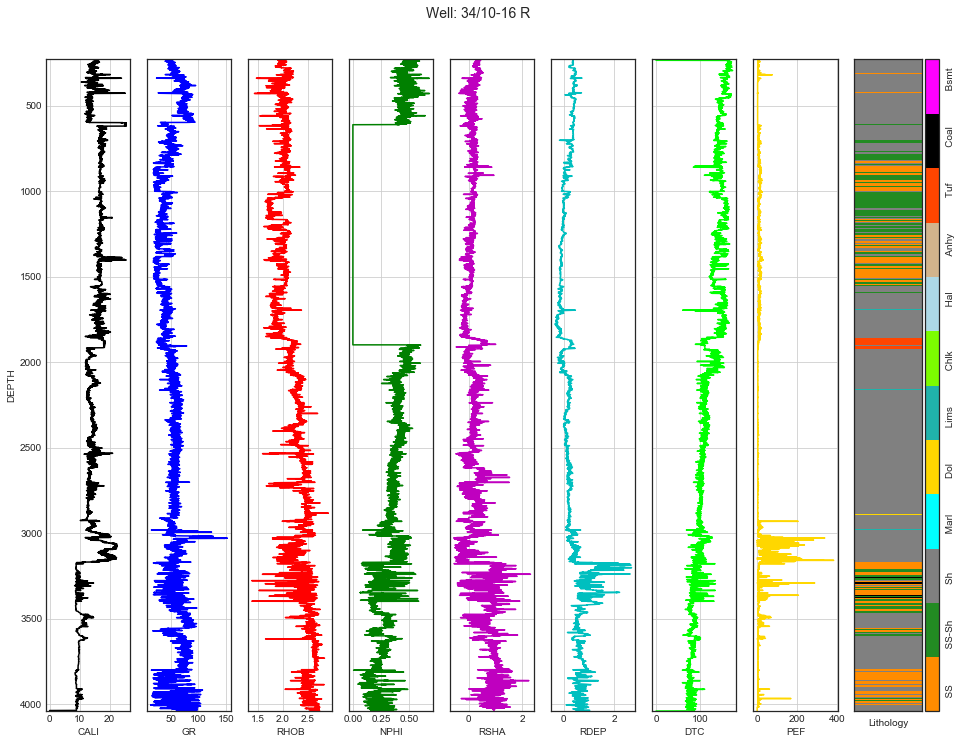

In [89]:
w=5
well_test=Series(well[Alldata.Dataset=='Test'].to_numpy())
logs = pd.concat([Xtest, #depth_test, 
                  DataFrame(test_prediction)], axis=1).rename(columns = {0:'litho_real', 'DEPTH_MD':'Depth'})
make_facies_log_plot(logs[well_test==test_wells[w]], ['CALI', 'GR', 'RHOB', 'NPHI', 'RSHA', 'RDEP', 'DTC', 'PEF'],
                     test_wells[w],
                     facies_colors)

In [90]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}

In [91]:
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)

In [92]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 65030, 65030, 65030])

In [93]:
np.savetxt('test_predictions.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

In [166]:
!pip freeze > requirements.txt